Part 1: Load and split data


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the cleaned data
cleaned_data = pd.read_csv('/Users/shailtp/Desktop/CSC_859_Project/Cleaned_Student_Performance_Dataset.csv')

# Drop unnamed or irrelevant columns
cleaned_data = cleaned_data.loc[:, ~cleaned_data.columns.str.contains('^Unnamed')]  # Remove unnamed columns

# Preprocess: Convert categorical variables to numeric
cleaned_data['Participation in Extracurricular Activities'] = cleaned_data['Participation in Extracurricular Activities'].map({'Yes': 1, 'No': 0})
cleaned_data['Parent Education Level'] = cleaned_data['Parent Education Level'].map({
    'High School': 0, 'Associate': 1, 'Bachelor': 2, 'Master': 3
})
cleaned_data['Passed'] = cleaned_data['Passed'].map({'Yes': 1, 'No': 0})

# Separate features and target variable
X = cleaned_data.drop(columns=['Passed', 'Student ID'])  # Features (dropping Student ID as it's not a feature)
y = cleaned_data['Passed']  # Target

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Part 2: Hyperparameter Tuning and Setting Up Random Forest Model

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the Random Forest Classifier with OOB score enabled
rf_model = RandomForestClassifier(oob_score=True, random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [250, 500, 1000],  # Number of trees
    'max_features': ['sqrt', 'log2', None]  # Square root, log2 of features, or all features
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Part 3: Testing and Metrics

Total rows used for training: 16149
Total rows used for testing: 4038
Confusion Matrix:
[[1061  989]
 [1005  983]]
Accuracy: 0.5061911837543338
Recall: 0.49446680080482897
Precision: 0.4984787018255578
F1 Score: 0.49646464646464644
Best Parameters: {'max_features': 'sqrt', 'n_estimators': 1000}
OOB Score: 0.49897826490804387


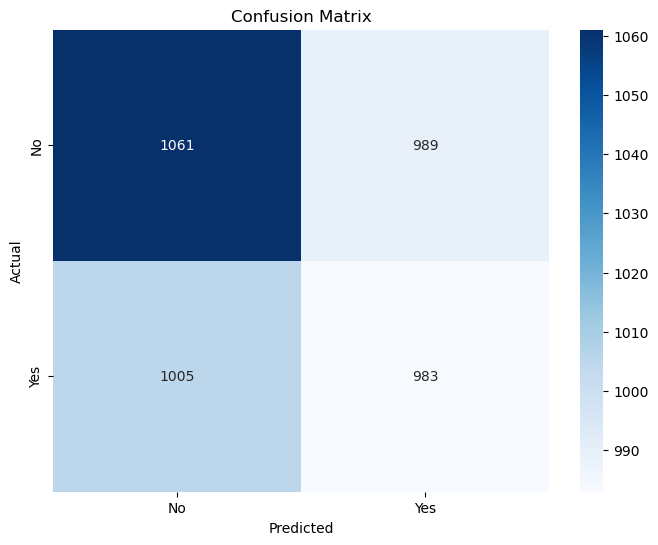

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Test the model on the testing data
y_pred = best_rf_model.predict(X_test)

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display metrics
print(f"Total rows used for training: {len(X_train)}")
print(f"Total rows used for testing: {len(X_test)}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"OOB Score: {best_rf_model.oob_score_}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Part 4: Feature Ranking using Gini Index

Feature Importance Ranking:
                                       Feature  Importance
2                              Previous Grades    0.330859
1                              Attendance Rate    0.328408
0                         Study Hours per Week    0.275561
4                       Parent Education Level    0.046637
3  Participation in Extracurricular Activities    0.018535


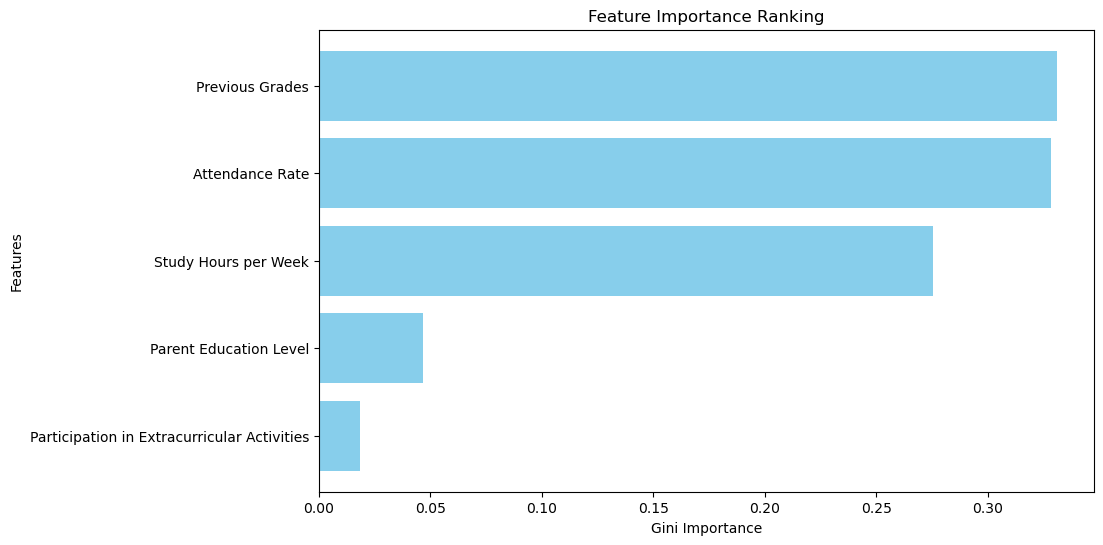

In [40]:
# Extract feature importances from the best model
feature_importances = best_rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importance ranking
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature rankings
print("Feature Importance Ranking:")
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.title('Feature Importance Ranking')
plt.show()


Part 5: Train the model with the three most important features

In [44]:
# Select top 3 features based on importance
selected_features = importance_df['Feature'].iloc[:3].tolist()
X_top3 = cleaned_data[selected_features]  # Use only the top 3 features

# Split data into 80% training and 20% testing
X_train_top3, X_test_top3, y_train_top3, y_test_top3 = train_test_split(X_top3, y, test_size=0.2, random_state=42)

# Train the model with top 3 features using the best parameters
rf_model_top3 = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_features=grid_search.best_params_['max_features'],
    random_state=42,
    oob_score=True
)
rf_model_top3.fit(X_train_top3, y_train_top3)

RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=42)

Part 6: Test the model with top 3 features


Metrics for Model with Top 3 Features:
Confusion Matrix:
[[1040 1010]
 [1034  954]]
Accuracy: 0.4938088162456662
Recall: 0.4798792756539235
Precision: 0.48574338085539714
F1 Score: 0.48279352226720645
OOB Score: 0.4975540281131959


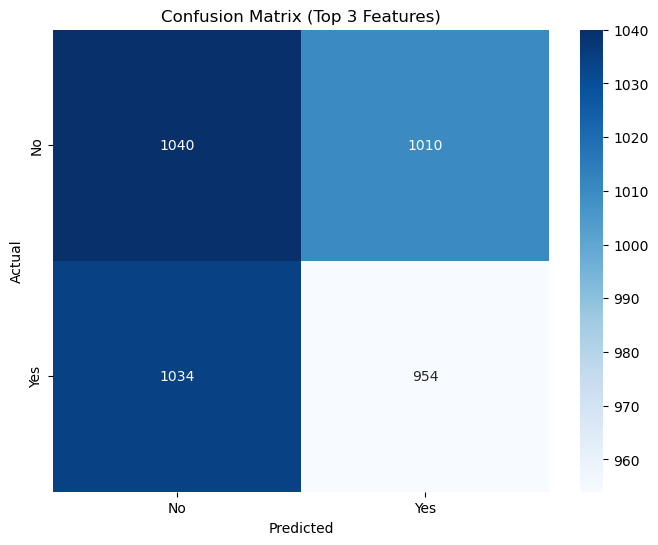

In [47]:
y_pred_top3 = rf_model_top3.predict(X_test_top3)

# Calculate metrics for top 3 features
conf_matrix_top3 = confusion_matrix(y_test_top3, y_pred_top3)
accuracy_top3 = accuracy_score(y_test_top3, y_pred_top3)
recall_top3 = recall_score(y_test_top3, y_pred_top3)
precision_top3 = precision_score(y_test_top3, y_pred_top3)
f1_top3 = f1_score(y_test_top3, y_pred_top3)

# Display metrics for top 3 features
print("\nMetrics for Model with Top 3 Features:")
print(f"Confusion Matrix:\n{conf_matrix_top3}")
print(f"Accuracy: {accuracy_top3}")
print(f"Recall: {recall_top3}")
print(f"Precision: {precision_top3}")
print(f"F1 Score: {f1_top3}")
print(f"OOB Score: {rf_model_top3.oob_score_}")

# Plot confusion matrix for top 3 features
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_top3, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Top 3 Features)')
plt.show()


The low accuracy and other performance metrics, even after using the three most important features, could be attributed to several factors. One significant reason is overfitting, which occurs when the model becomes overly tailored to the training data, especially when using a subset of features. 

Class imbalance or insufficient correlation between the selected features and the target outcome is also contributing to poor generalization on testing data. These limitations underline the importance of careful feature selection and possibly integrating additional preprocessing techniques, such as addressing class imbalances or using alternative models, to enhance performance.

We have tried gridsearch to choose the best parameters and also used feature ranking to just include the important features during traning but still have poor results. The primary reason for this can be that the dataset does not have enough features to correlate a realtionship between the target variable and the features used for training.


Part 6: Predict Probabilities for Specific Samples

In [56]:
# Ensure the test samples match the trained model's features
true_positive_sample = X_test_top3[y_test_top3 == 1].iloc[0]  # Picking the first instance of class 1
true_negative_sample = X_test_top3[y_test_top3 == 0].iloc[0]  # Picking the first instance of class 0

# Create a DataFrame to store these samples for easier prediction
test_samples = pd.DataFrame([true_positive_sample, true_negative_sample], columns=X_train_top3.columns)
test_samples_labels = pd.Series([1, 0], index=[0, 1])  # Known labels for the selected samples

# Use the best-trained model to predict probabilities
predicted_probs = rf_model_top3.predict_proba(test_samples)

# Display the predicted probabilities
print("\nPredicted Probabilities for Specific Samples:")
for i, probs in enumerate(predicted_probs):
    determined_class = int(probs[1] >= 0.5)  # Default cutoff of 0.5 for classifying
    print(f"Sample {i + 1}:")
    print(f"  True Label: {test_samples_labels[i]}")
    print(f"  Predicted Class: {determined_class}")
    print(f"  Probability for Class 0: {probs[0]:.3f}")
    print(f"  Probability for Class 1: {probs[1]:.3f}")
    print(f"  Correct Classification: {determined_class == test_samples_labels[i]}")


Predicted Probabilities for Specific Samples:
Sample 1:
  True Label: 1
  Predicted Class: 1
  Probability for Class 0: 0.250
  Probability for Class 1: 0.750
  Correct Classification: True
Sample 2:
  True Label: 0
  Predicted Class: 1
  Probability for Class 0: 0.445
  Probability for Class 1: 0.555
  Correct Classification: False
